# Importing Necessary Libraries

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import platform
import pandas as pd
import numpy as np
import torch.nn as nn
#import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
model='roberta-base'

In [18]:
print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No Cuda!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Python version: 3.11.12
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU model: Tesla T4
Number of GPUs: 1
Available GPU memory: 15.83 GB
Using device: cuda


In [19]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
path = "/content/drive/MyDrive/nndl"

# Model trained on iSarcasmEval

In [21]:
df_train_iSarcasm = pd.read_csv(path+'/iSarcasmEval/train.csv')
df_val_iSarcasm = pd.read_csv(path+'/iSarcasmEval/val.csv')
df_test_iSarcasm = pd.read_csv(path+'/iSarcasmEval/test.csv')

In [22]:
df_train_iSarcasm.head()

,text,sarcastic
0,"Fuck, an Insomniac developed Wolverine game?! ...",0
1,There are people who say there is no hope left...,0
2,"Well, what a way to ruin Easter. Thanks @Cadbu...",1
3,excited to start my new hobby of standing in t...,0
4,Nothing quite says “back to work January blues...,0


In [23]:
# Calculate class weights for weighted loss
# give higher weights to 1 class, and lower weights to 0 class
class_labels_iSarcasm = np.unique(df_train_iSarcasm['sarcastic'])
class_weights_iSarcasm = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_iSarcasm,
    y=df_train_iSarcasm['sarcastic'].tolist()
)
weights_tensor_iSarcasm = torch.tensor(class_weights_iSarcasm, dtype=torch.float)
print(f"Calculated class labels for iSarcasmEval: {class_labels_iSarcasm}")
print(f"Calculated class weights for iSarcasmEval: {weights_tensor_iSarcasm}")

Calculated class labels for iSarcasmEval: [0 1]
Calculated class weights for iSarcasmEval: tensor([0.6667, 1.9993])


In [24]:
# Creating weighted loss
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [26]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [27]:
# Creating the PyTorch Datasets
MAX_LEN = 128

train_dataset_iSarcasm = SarcasmDataset(
    texts=df_train_iSarcasm['text'].tolist(),
    labels=df_train_iSarcasm['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset_iSarcasm = SarcasmDataset(
    texts=df_val_iSarcasm['text'].tolist(),
    labels=df_val_iSarcasm['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset_iSarcasm = SarcasmDataset(
    texts=df_test_iSarcasm['text'].tolist(),
    labels=df_test_iSarcasm['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

print(f"Length of iSarcasmEval training dataset: {len(train_dataset_iSarcasm)}")
print(f"Length of iSarcasmEval validation dataset: {len(val_dataset_iSarcasm)}")
print(f"Length of iSarcasmEval test dataset: {len(test_dataset_iSarcasm)}")

Length of iSarcasmEval training dataset: 2947
Length of iSarcasmEval validation dataset: 521
Length of iSarcasmEval test dataset: 1400


In [28]:
model_iSarcasm = AutoModelForSequenceClassification.from_pretrained(
    model,
    num_labels=2  # We have binary classification: sarcastic (1) or not sarcastic (0)
)

# Function to compute metrics and heatmap
def compute_metrics_iSarcasm(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    #  basic metrics
    precision_binary, recall_binary, f1_binary, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # weighted metrics
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    # confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Sarcastic', 'Sarcastic'],
                yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (iSarcasmEval Validation)')
    plt.show()

    return {
        'accuracy': acc,
        'f1_binary': f1_binary,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
    }

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Training Params
training_args_iSarcasm = TrainingArguments(
    output_dir=path+'/results_iSarcasm',          # Directory to save model checkpoints and final model
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.01,


    logging_strategy="epoch",
    report_to="none",

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",      # Metric to determine the best model
    greater_is_better=False,
    fp16=torch.cuda.is_available(),           # Use mixed precision training if a GPU is available
    save_total_limit=2,                        # Only keep the last 2 checkpoints + the best one
    dataloader_num_workers=8
)

In [14]:
#model_iSarcasm = torch.compile(model_iSarcasm, mode="default")

In [30]:
# Initializing the Trainer
trainer_iSarcasm = WeightedLossTrainer(
        model=model_iSarcasm,
        args=training_args_iSarcasm,
        train_dataset=train_dataset_iSarcasm,
        eval_dataset=val_dataset_iSarcasm,
        compute_metrics=compute_metrics_iSarcasm,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        class_weights=weights_tensor_iSarcasm
    )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Binary,Precision Binary,Recall Binary,F1 Weighted,Precision Weighted,Recall Weighted
1,0.697800,0.688890,0.635317,0.301471,0.288732,0.315385,0.640519,0.646290,0.635317
2,0.662200,0.640923,0.740883,0.405286,0.474227,0.353846,0.727294,0.720129,0.740883
3,0.520000,0.757954,0.752399,0.382775,0.506329,0.307692,0.729769,0.724007,0.752399
4,0.338900,1.128232,0.750480,0.308511,0.500000,0.223077,0.713218,0.711528,0.750480


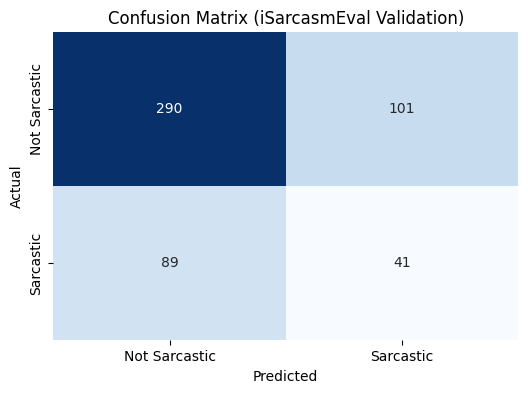

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


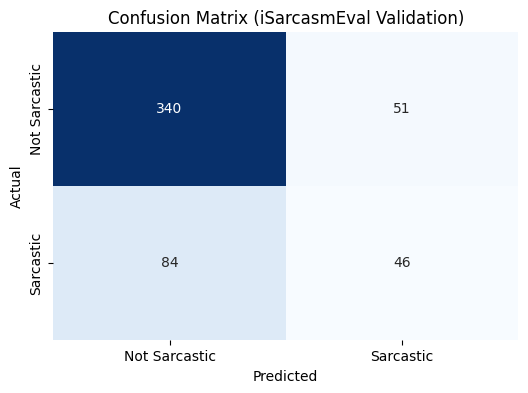

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


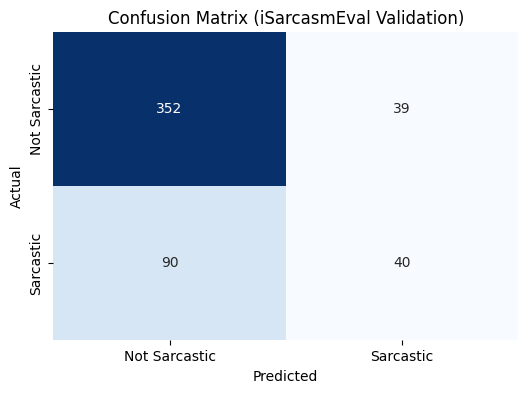

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


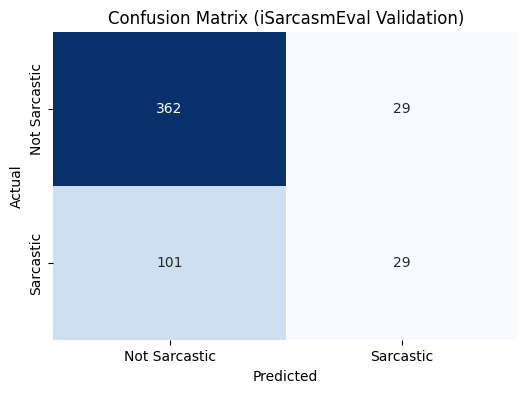

Best model for iSarcasmEval saved to /content/drive/MyDrive/nndl/results_iSarcasm/best_model_iSarcasmEval


In [31]:
# Training
train_result_iSarcasm = trainer_iSarcasm.train()
trainer_iSarcasm.save_model(path+"/results_iSarcasm/best_model_iSarcasmEval")
tokenizer.save_pretrained(path+"/results_iSarcasm/best_model_iSarcasmEval")
print(f"Best model for iSarcasmEval saved to {path}/results_iSarcasm/best_model_iSarcasmEval")

Plotting training and validation loss...


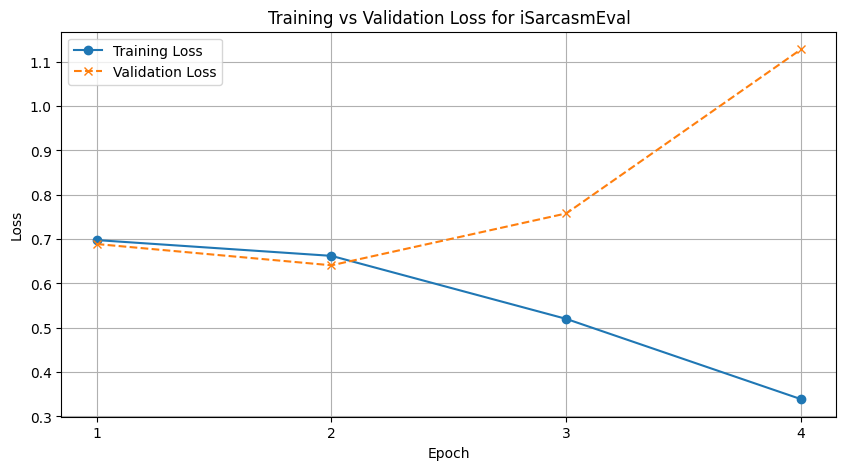

In [32]:
print("Plotting training and validation loss...")
log_history = trainer_iSarcasm.state.log_history

training_loss = []
validation_loss = []
epochs_train = []
epochs_val = []

for log_entry in log_history:
    if 'loss' in log_entry:  # Training log
        training_loss.append(log_entry['loss'])
        epochs_train.append(log_entry['epoch'])
    if 'eval_loss' in log_entry:  # Evaluation log
        validation_loss.append(log_entry['eval_loss'])
        epochs_val.append(log_entry['epoch'])

if not training_loss and not validation_loss:
    print("No training or validation loss found in log_history. Ensure logging_strategy was not 'no'.")
else:
    plt.figure(figsize=(10, 5))
    if training_loss:
        plt.plot(epochs_train, training_loss, label='Training Loss', marker='o', linestyle='-')
    if validation_loss:
        plt.plot(epochs_val, validation_loss, label='Validation Loss', marker='x', linestyle='--')

    plt.title('Training vs Validation Loss for iSarcasmEval')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks([int(e) for e in sorted(list(set(epochs_train + epochs_val))) if e == int(e)])
    plt.show()


Evaluating the iSarcasmEval model on the test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


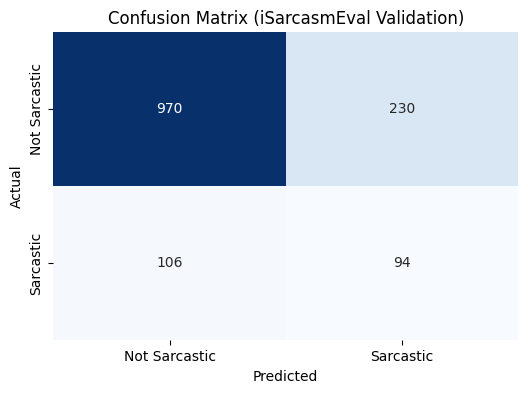


Test Set Evaluation Metrics for iSarcasmEval Model:
test_accuracy: 0.7600
test_f1_binary: 0.3588
test_precision_binary: 0.2901
test_recall_binary: 0.4700
test_f1_weighted: 0.7819
test_precision_weighted: 0.8141
test_recall_weighted: 0.7600
test_runtime: 3.0224
test_samples_per_second: 463.2120
test_steps_per_second: 14.5580


In [33]:
print("\nEvaluating the iSarcasmEval model on the test set...")
# We perform prediction on the test set
test_predictions_iSarcasm = trainer_iSarcasm.predict(test_dataset_iSarcasm)
print("\nTest Set Evaluation Metrics for iSarcasmEval Model:")
if test_predictions_iSarcasm.metrics:
    for key, value in test_predictions_iSarcasm.metrics.items():
        if 'loss' not in key:
             print(f"{key}: {value:.4f}")
else:
    print("No metrics returned from predict.")

# Model trained on Sarcasm_Corpus_V2

In [35]:
df_train_Sarcasm_Corpus_V2 = pd.read_csv(path+'/Sarcasm_Corpus_V2/train.csv')
df_val_Sarcasm_Corpus_V2 = pd.read_csv(path+'/Sarcasm_Corpus_V2/val.csv')
df_test_Sarcasm_Corpus_V2 = pd.read_csv(path+'/Sarcasm_Corpus_V2/test.csv')

In [36]:
df_train_Sarcasm_Corpus_V2.head()

,text,sarcastic
0,wow - sounds like a terrible idea. luckily we ...,0
1,But a business is just a private citizen! Why ...,1
2,"thewayitis, i would say is one of the best deb...",0
3,"The lovely thing about our system of justice, ...",1
4,And the wonders all around us show us how. . .,0


In [37]:
# Calculate class weights for weighted loss
# give higher weights to 1 class, and lower weights to 0 class
# No need for weighted loss, since classes are balanced
class_labels_Sarcasm_Corpus_V2 = np.unique(df_train_Sarcasm_Corpus_V2['sarcastic'])
class_weights_Sarcasm_Corpus_V2 = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_Sarcasm_Corpus_V2,
    y=df_train_Sarcasm_Corpus_V2['sarcastic'].tolist()
)
weights_tensor_Sarcasm_Corpus_V2= torch.tensor(class_weights_Sarcasm_Corpus_V2, dtype=torch.float)
print(f"Calculated class labels for Sarcasm_Corpus_V2: {class_labels_Sarcasm_Corpus_V2}")
print(f"Calculated class weights for Sarcasm_Corpus_V2: {weights_tensor_Sarcasm_Corpus_V2}")

Calculated class labels for Sarcasm_Corpus_V2: [0 1]
Calculated class weights for Sarcasm_Corpus_V2: tensor([0.9998, 1.0002])


In [38]:
tokenizer = AutoTokenizer.from_pretrained(model)

In [39]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [40]:
# Creating the PyTorch Datasets
MAX_LEN = 128

train_dataset_Sarcasm_Corpus_V2 = SarcasmDataset(
    texts=df_train_Sarcasm_Corpus_V2['text'].tolist(),
    labels=df_train_Sarcasm_Corpus_V2['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset_Sarcasm_Corpus_V2 = SarcasmDataset(
    texts=df_val_Sarcasm_Corpus_V2['text'].tolist(),
    labels=df_val_Sarcasm_Corpus_V2['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset_Sarcasm_Corpus_V2 = SarcasmDataset(
    texts=df_test_Sarcasm_Corpus_V2['text'].tolist(),
    labels=df_test_Sarcasm_Corpus_V2['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

print(f"Length of Sarcasm_Corpus_V2 training dataset: {len(train_dataset_Sarcasm_Corpus_V2)}")
print(f"Length of Sarcasm_Corpus_V2 validation dataset: {len(val_dataset_Sarcasm_Corpus_V2)}")
print(f"Length of Sarcasm_Corpus_V2 test dataset: {len(test_dataset_Sarcasm_Corpus_V2)}")

Length of Sarcasm_Corpus_V2 training dataset: 6381
Length of Sarcasm_Corpus_V2 validation dataset: 1127
Length of Sarcasm_Corpus_V2 test dataset: 1878


In [41]:
model_Sarcasm_Corpus_V2 = AutoModelForSequenceClassification.from_pretrained(
    model,
    num_labels=2  # We have binary classification: sarcastic (1) or not sarcastic (0)
)

# Function to compute metrics and heatmap
def compute_metrics_Sarcasm_Corpus_V2(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    #  basic metrics
    precision_binary, recall_binary, f1_binary, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # weighted metrics
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    # confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Sarcastic', 'Sarcastic'],
                yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Sarcasm_Corpus_V2 Validation)')
    plt.show()

    return {
        'accuracy': acc,
        'f1_binary': f1_binary,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
    }

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Training Params
training_args_Sarcasm_Corpus_V2 = TrainingArguments(
    output_dir=path+'/results_Sarcasm_Corpus_V2',          # Directory to save model checkpoints and final model
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.01,


    logging_strategy="epoch",
    report_to="none",

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",      # Metric to determine the best model
    greater_is_better=False,
    fp16=torch.cuda.is_available(),           # Use mixed precision training if a GPU is available
    save_total_limit=2,                        # Only keep the last 2 checkpoints + the best one
    dataloader_num_workers=8
)

In [44]:
# Initializing the Trainer
trainer_Sarcasm_Corpus_V2 = Trainer(
        model=model_Sarcasm_Corpus_V2,
        args=training_args_Sarcasm_Corpus_V2,
        train_dataset=train_dataset_Sarcasm_Corpus_V2,
        eval_dataset=val_dataset_Sarcasm_Corpus_V2,
        compute_metrics=compute_metrics_Sarcasm_Corpus_V2,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Binary,Precision Binary,Recall Binary,F1 Weighted,Precision Weighted,Recall Weighted
1,0.511400,0.446236,0.805679,0.798157,0.831094,0.767730,0.805402,0.807482,0.805679
2,0.363400,0.456351,0.795031,0.787097,0.819578,0.757092,0.794739,0.796773,0.795031
3,0.253600,0.678541,0.800355,0.813896,0.762791,0.872340,0.799305,0.806668,0.800355


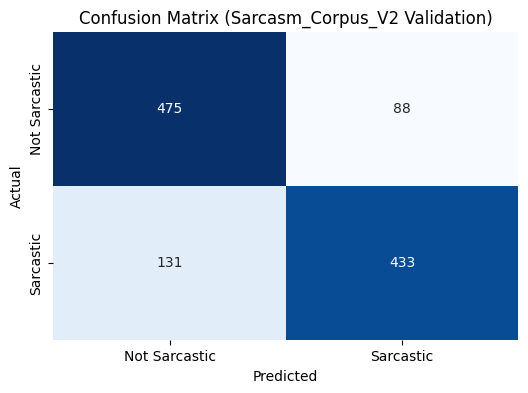

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


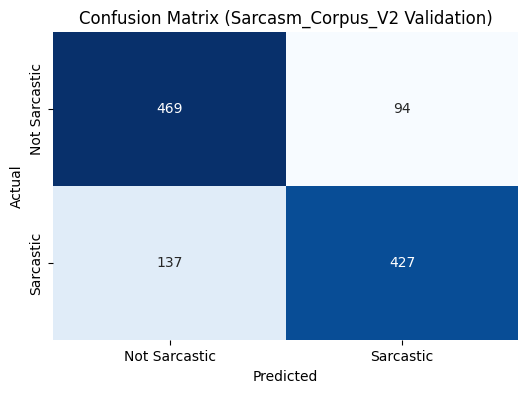

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


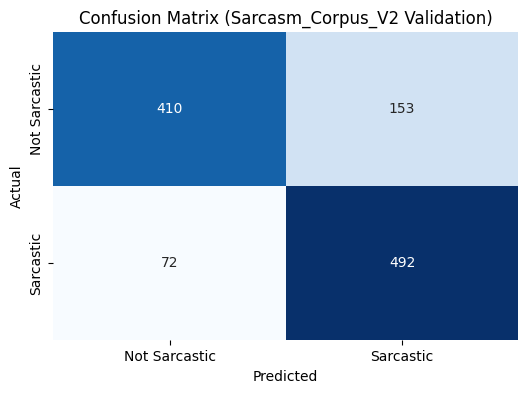

Best model for Sarcasm_Corpus_V2 saved to /content/drive/MyDrive/nndl/results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2


In [45]:
# Training
train_result_Sarcasm_Corpus_V2 = trainer_Sarcasm_Corpus_V2.train()
trainer_Sarcasm_Corpus_V2.save_model(path+"/results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2")
tokenizer.save_pretrained(path+"/results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2")
print(f"Best model for Sarcasm_Corpus_V2 saved to {path}/results_Sarcasm_Corpus_V2/best_model_Sarcasm_Corpus_V2")

Plotting training and validation loss...


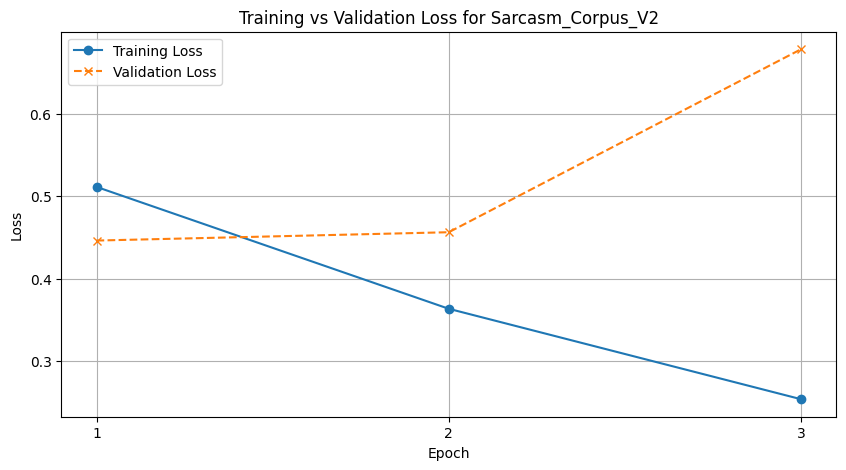

In [46]:
print("Plotting training and validation loss...")
log_history = trainer_Sarcasm_Corpus_V2.state.log_history

training_loss = []
validation_loss = []
epochs_train = []
epochs_val = []

for log_entry in log_history:
    if 'loss' in log_entry:  # Training log
        training_loss.append(log_entry['loss'])
        epochs_train.append(log_entry['epoch'])
    if 'eval_loss' in log_entry:  # Evaluation log
        validation_loss.append(log_entry['eval_loss'])
        epochs_val.append(log_entry['epoch'])

if not training_loss and not validation_loss:
    print("No training or validation loss found in log_history. Ensure logging_strategy was not 'no'.")
else:
    plt.figure(figsize=(10, 5))
    if training_loss:
        plt.plot(epochs_train, training_loss, label='Training Loss', marker='o', linestyle='-')
    if validation_loss:
        plt.plot(epochs_val, validation_loss, label='Validation Loss', marker='x', linestyle='--')

    plt.title('Training vs Validation Loss for Sarcasm_Corpus_V2')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks([int(e) for e in sorted(list(set(epochs_train + epochs_val))) if e == int(e)])
    plt.show()


Evaluating the Sarcasm_Corpus_V2 model on the test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


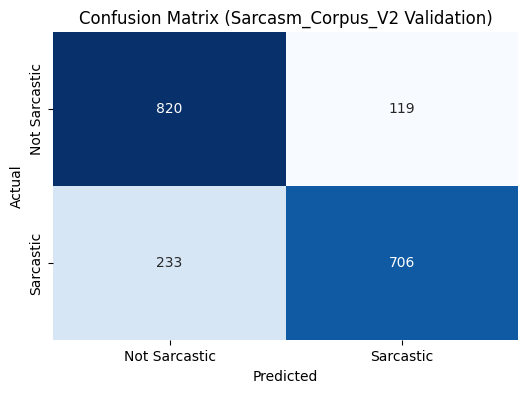


Test Set Evaluation Metrics for Sarcasm_Corpus_V2 Model:
test_accuracy: 0.8126
test_f1_binary: 0.8005
test_precision_binary: 0.8558
test_recall_binary: 0.7519
test_f1_weighted: 0.8119
test_precision_weighted: 0.8172
test_recall_weighted: 0.8126
test_runtime: 4.6207
test_samples_per_second: 406.4280
test_steps_per_second: 12.7680


In [47]:
print("\nEvaluating the Sarcasm_Corpus_V2 model on the test set...")
# We perform prediction on the test set
test_predictions_Sarcasm_Corpus_V2 = trainer_Sarcasm_Corpus_V2.predict(test_dataset_Sarcasm_Corpus_V2)
print("\nTest Set Evaluation Metrics for Sarcasm_Corpus_V2 Model:")
if test_predictions_Sarcasm_Corpus_V2.metrics:
    for key, value in test_predictions_Sarcasm_Corpus_V2.metrics.items():
        if 'loss' not in key:
             print(f"{key}: {value:.4f}")
else:
    print("No metrics returned from predict.")

# Model trained on Combined dataset (iSarcasmEval +Sarcasm_Corpus_V2)

In [49]:
df_train_combined = pd.read_csv(path+'/combined/train.csv')
df_val_combined = pd.read_csv(path+'/combined/val.csv')
df_test_combined = pd.read_csv(path+'/combined/test.csv')

In [50]:
df_train_combined.head()

,text,sarcastic
0,I haven’t seen my best friend in over a year I...,0
1,And you people whine at me about using persona...,0
2,Would you care to explain exactly what was lac...,0
3,This tennis is hilariously fantastic to watch....,0
4,"So, the Supreme Court rested its decision not ...",0


In [51]:
# Calculate class weights for weighted loss
# give higher weights to 1 class, and lower weights to 0 class
# They have similar samples, so no weighted loss is needed
class_labels_combined = np.unique(df_train_combined['sarcastic'])
class_weights_combined = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_combined,
    y=df_train_combined['sarcastic'].tolist()
)
weights_tensor_combined = torch.tensor(class_weights_combined, dtype=torch.float)
print(f"Calculated class labels for Combined Dataset: {class_labels_combined}")
print(f"Calculated class weights for Combined Dataset: {weights_tensor_combined}")

Calculated class labels for Combined Dataset: [0 1]
Calculated class weights for Combined Dataset: tensor([0.8635, 1.1877])


In [52]:
tokenizer = AutoTokenizer.from_pretrained(model)

In [53]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [54]:
# Creating the PyTorch Datasets
MAX_LEN = 128

train_dataset_combined = SarcasmDataset(
    texts=df_train_combined['text'].tolist(),
    labels=df_train_combined['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset_combined  = SarcasmDataset(
    texts=df_val_combined['text'].tolist(),
    labels=df_val_combined['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset_combined  = SarcasmDataset(
    texts=df_test_combined['text'].tolist(),
    labels=df_test_combined['sarcastic'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

print(f"Length of Combined training dataset: {len(train_dataset_combined)}")
print(f"Length of Combined validation dataset: {len(val_dataset_combined)}")
print(f"Length of Combined test dataset: {len(test_dataset_combined)}")

Length of Combined training dataset: 9328
Length of Combined validation dataset: 1648
Length of Combined test dataset: 3278


In [55]:
model_combined = AutoModelForSequenceClassification.from_pretrained(
    model,
    num_labels=2  # We have binary classification: sarcastic (1) or not sarcastic (0)
)

# Function to compute metrics and heatmap
def compute_metrics_combined(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    #  basic metrics
    precision_binary, recall_binary, f1_binary, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # weighted metrics
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    # confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Sarcastic', 'Sarcastic'],
                yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Combined Dataset Validation)')
    plt.show()

    return {
        'accuracy': acc,
        'f1_binary': f1_binary,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
    }

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
# Training Params
training_args_combined = TrainingArguments(
    output_dir=path+'/results_combined',          # Directory to save model checkpoints and final model
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.01,


    logging_strategy="epoch",
    report_to="none",

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",      # Metric to determine the best model
    greater_is_better=False,
    fp16=torch.cuda.is_available(),           # Use mixed precision training if a GPU is available
    save_total_limit=2,                        # Only keep the last 2 checkpoints + the best one
    dataloader_num_workers=8
)

In [57]:
# Initializing the Trainer
trainer_combined = Trainer(
        model=model_combined,
        args=training_args_combined,
        train_dataset=train_dataset_combined,
        eval_dataset=val_dataset_combined,
        compute_metrics=compute_metrics_combined,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Binary,Precision Binary,Recall Binary,F1 Weighted,Precision Weighted,Recall Weighted
1,0.547600,0.471183,0.777913,0.700491,0.810606,0.616715,0.771716,0.782758,0.777913
2,0.394200,0.508126,0.788228,0.697311,0.875817,0.579251,0.778258,0.805540,0.788228
3,0.278000,0.579635,0.784587,0.724593,0.784874,0.672911,0.781628,0.784614,0.784587


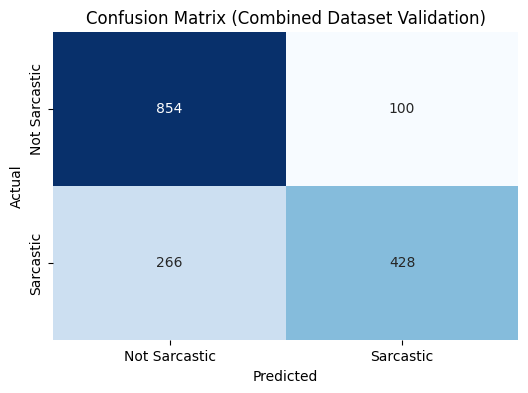

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


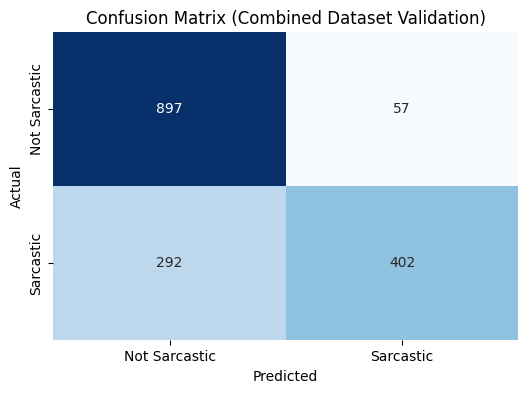

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


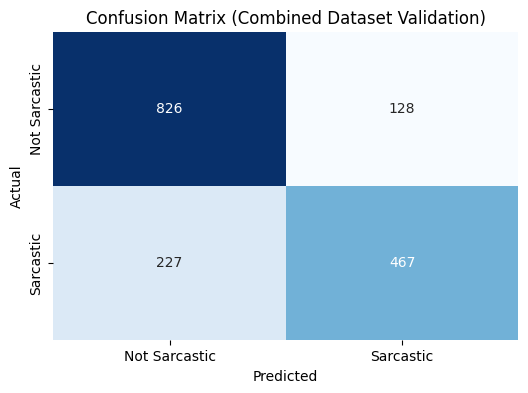

Best model for Combined Dataset saved to /content/drive/MyDrive/nndl/results_combined/best_model_combined


In [58]:
# Training
train_result_combined = trainer_combined.train()
trainer_combined.save_model(path+"/results_combined/best_model_combined")
tokenizer.save_pretrained(path+"/results_combined/best_model_combined")
print(f"Best model for Combined Dataset saved to {path}/results_combined/best_model_combined")

Plotting training and validation loss...


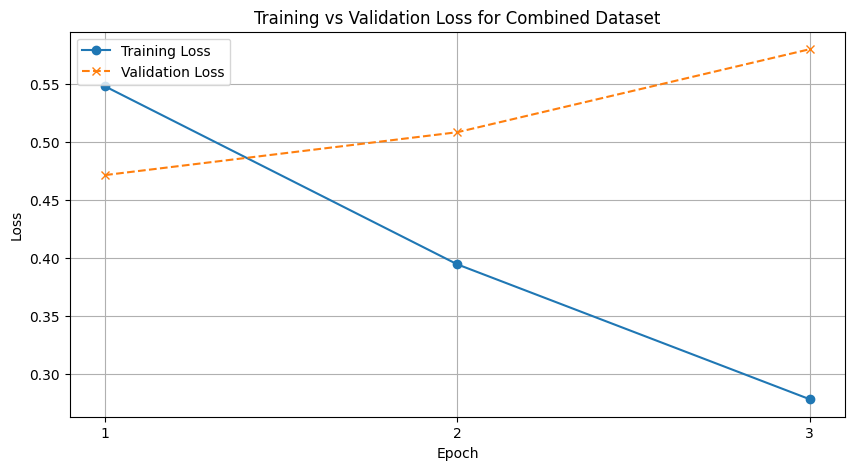

In [59]:
print("Plotting training and validation loss...")
log_history = trainer_combined.state.log_history

training_loss = []
validation_loss = []
epochs_train = []
epochs_val = []

for log_entry in log_history:
    if 'loss' in log_entry:  # Training log
        training_loss.append(log_entry['loss'])
        epochs_train.append(log_entry['epoch'])
    if 'eval_loss' in log_entry:  # Evaluation log
        validation_loss.append(log_entry['eval_loss'])
        epochs_val.append(log_entry['epoch'])

if not training_loss and not validation_loss:
    print("No training or validation loss found in log_history. Ensure logging_strategy was not 'no'.")
else:
    plt.figure(figsize=(10, 5))
    if training_loss:
        plt.plot(epochs_train, training_loss, label='Training Loss', marker='o', linestyle='-')
    if validation_loss:
        plt.plot(epochs_val, validation_loss, label='Validation Loss', marker='x', linestyle='--')

    plt.title('Training vs Validation Loss for Combined Dataset')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks([int(e) for e in sorted(list(set(epochs_train + epochs_val))) if e == int(e)])
    plt.show()


Evaluating the Combined model on the test set...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


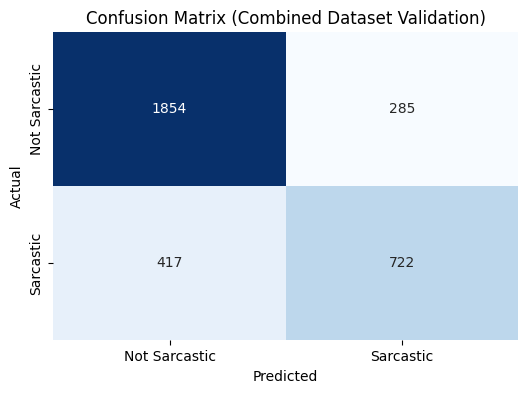


Test Set Evaluation Metrics for Combined Model:
test_accuracy: 0.7858
test_f1_binary: 0.6729
test_precision_binary: 0.7170
test_recall_binary: 0.6339
test_f1_weighted: 0.7825
test_precision_weighted: 0.7818
test_recall_weighted: 0.7858
test_runtime: 6.3238
test_samples_per_second: 518.3570
test_steps_per_second: 16.2880


In [60]:
print("\nEvaluating the Combined model on the test set...")
# We perform prediction on the test set
test_predictions_combined = trainer_combined.predict(test_dataset_combined)
print("\nTest Set Evaluation Metrics for Combined Model:")
if test_predictions_combined.metrics:
    for key, value in test_predictions_combined.metrics.items():
        if 'loss' not in key:
             print(f"{key}: {value:.4f}")
else:
    print("No metrics returned from predict.")